# Estimating TRE from FLE and Tool Design

In this worksheet, we will investigate the effect on TRE of both FLE and tool design. An excellent reference in this area is [West and Maurer 2004](http://dx.doi.org/10.1109/TMI.2004.825614), which has a very thorough explanation of the theory, and a very widely applicable simulation, and experimental verification. 

This worksheet gives a simpler, but still sufficiently illustrative example of how the theory can be useful.

In [1]:
%matplotlib inline

In [2]:
# Jupyter notebook sets the cwd to the folder containing the notebook.
# So, you want to add the root of the project to the sys path, so modules load correctly.
import sys
sys.path.append("../../")

In [3]:
# All other imports
import numpy as np
import matplotlib.pyplot as plt
import sksurgerycore.transforms.matrix as mat
import sksurgerycore.algorithms.procrustes as pro
import sksurgerycore.algorithms.errors as err

In [4]:
# Various useful functions, to ensure we get enough done in a workshop.
def make_pointer(width, length, tip_distance, is_cross):
    """
    Function to generate fiducial locations, and tip position for a simple pointer model.
    Refer to West and Maurer, Figure 2 (d) and (e).
    
    :param width: width of fiducials in mmilimetres (horizontal distance, if you are reading paper)
    :param length: length of fiducials in millimetres (vertical distance, if you are reading paper)
    :param tip_distance: distance from centroid to pointer tip, along y-axis
    :param is_cross: See West And Maurer, if is_cross=True, generates shape like 2(d), and if is_cross is false, like 2(e)
    """
    markers = np.zeros((4, 3))
    tip = np.zeros((1,3))
    
    if is_cross:
        markers[0][0] = -width/2.
        markers[1][0] =  width/2.
        markers[2][1] = -length/2.
        markers[3][1] =  length/2.
    else:
        markers[0][0] = -width/2.
        markers[0][1] = -length/2.
        markers[1][0] =  width/2.
        markers[1][1] = -length/2.
        markers[2][0] = -width/2.
        markers[2][1] =  length/2.
        markers[3][0] =  width/2.
        markers[3][1] =  length/2.
    tip[0][1] = tip_distance 
    return markers, tip

In [5]:
# This cell illustrates how to create marker coordinates and a tip coordinate, using the above method.
markers, tip = make_pointer(40, 100, 100, False)
print("Markers are:\n" + str(markers))
print("Tip is:\n" + str(tip))

Markers are:
[[-20. -50.   0.]
 [ 20. -50.   0.]
 [-20.  50.   0.]
 [ 20.  50.   0.]]
Tip is:
[[  0. 100.   0.]]


Try drawing those points on paper, with +x-axis going rightwards, +y-axis going downwards.

The next cell calls a SNAPPY function [here](https://github.com/UCL/scikit-surgerycore/blob/master/sksurgerycore/algorithms/errors.py), which implements 

\begin{equation}
    \langle TRE^2({\bf p}) \rangle \approx \frac{ \langle FLE^2 \rangle }{N} \left( 1 + \frac{1}{3} \sum_{k=1}^3 \frac{d_k^2}{f_k^2} \right)
\end{equation}

Tracker manufacturers typically quote RMS values, which is the square root of the, mean (expectation), of the squared error. For example, [NDI quote 0.25 mm rms for polaris spectra](https://www.ndigital.com/medical/products/polaris-family/). The function takes an $Nx3$ list of fiducial points in the coordinate system of the tool, the mean FLE squared and an $1x3$ target point in the same coordinate system. The function returns the estimate according to the above formula, of the mean TRE squared.


In [6]:
# Example of calling compute_tre_from_fle(fiducial_markers, mean_FLE_squared, tip/target_location)
mean_tre_squared = err.compute_tre_from_fle(markers, 0.25 * 0.25, tip)
print(np.sqrt(mean_tre_squared))

0.2332768815126691


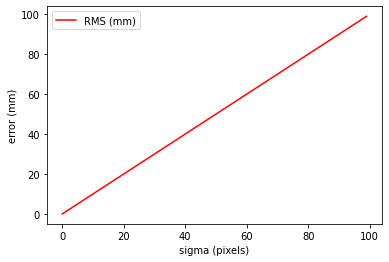

In [7]:
# Example of drawing a graph.
x_values = range(100) # ToDo: fill list with real data
y_values = range(100) # ToDo: fill list with real data
plt.plot(x_values, y_values, 'r', label='RMS (mm)')  
plt.legend(loc='upper left')
plt.xlabel('sigma (pixels)')
plt.ylabel('error (mm)')
plt.show()

# 1. Investigate Characteristics of a Pointer, using Formula

Yes, I know we have done a lot of work with a pointer. But, remember, the same logic also applies to endoscopes, laparoscopes and ultrasound probes. If you have tracking markers at one end, then in the case of the laparoscope or endoscope, you are interested in how accurately you can track the optical centre (origin) of the video pinhole camera model. In an ultrasound probe, the "target" might just be the centre of the ultrasound transducer that is some distance away from the tracking markers. These things are just easier to study with a pointer.... because its pointy, and you know where the tip is! (optical centre for a laparoscope, is somewhere inside the barrel).

Tasks

1. Create a set of marker fiducials for a pointer, say width=50mm, height=150mm, tip_distance=150
2. Create a graph of RMS TRE, as width varies
3. Create a graph of RMS TRE, as height varies
4. Create a graph of RMS TRE, as tip_distance varies



In [43]:
# Your code here.

So, the "tip_distance is the distance from the centroid.

5. Do these numbers look reasonable for a pointer, but what about a laparoscope?

# 2. Investigate the Characteristics of a Laparoscope using Formula

6. You can create a set of fiducials for a laparoscope, say width=50mm, height=60mm, tip_distance=300mm
7. Create a graph of error "in front of the camera", by simply increasing the length of tip_distance. So, x-axis goes from 300mm to 500mm, steps of 10mm. Y-axis is the output of compute_tre_from_fle function.

In [44]:
# Your code here.

# 3. Does it Match Simulation?

Look at West and Maurer 2004, section III (A), point 8. They add noise to fiducial markers

\begin{equation}
  \sigma = FLE / \sqrt{3}
\end{equation}

where FLE is the Fiducial Localisation Error of the tracker detecting the markers on an optically tracked tool. The paper uses a range of values. Lets just pick $\sigma = 0.25$, which is the quoted tracking accuracy of the NDI Spectra. However, be aware that tracking accuracy varies throughout the tracking volume, so even this is an average.

8. Add zero mean, Gaussian noise to fiducial markers.
9. Register noisy-fiducials back to un-noisy fiducials which gives a rotation and translation matrix
10. Compute 4x4,
11. Multiply target point by 4x4,
12. Compute the difference between the original noisy target point and the noise-misregistered one.
13. Repeat 8-12, say 1000 times, compute RMS error

See functions [sksurgerycore.algorithms.procrustes](https://github.com/UCL/scikit-surgerycore/-/blob/master/sksurgerycore/algorithms/procrustes.py) for Arun's method, and [sksurgerycore.transforms.matrix](https://github.com/UCL/scikit-surgerycore/-/blob/master/sksurgerycore/transforms/matrix.py#L169) to compute a 4x4 matrix from a rotation and translation vector.

In [45]:
# Your code here

# 4. Does a CRF Help?

Imagine you have a laparoscope of the above size. Place it a certain distance from the tracker, and another set of markers a reasonable distance as if next to the patient. For simplicity, just translate the points along the -z-axis.

14. Translate laparoscope fiducial markers -2000 in z. 
15. Create another set of markers for the CRF, width=80, height=80, tip_distance=0, is_cross=False
16. Translate these markers say -1500 in z.
17. As above, add zero mean, Gaussian noise to each fiducial, recompute tracking matrices by registering noisy fiducials to un-noise fiducials. Don't forget to do this twice, once for the laparoscope, once for the marker.
18. Compute whether the chosen tip position would be, if you multiplied by the laparoscope-fiducials-to-tracker matrix, and the inverse of the CRF-to-tracker-matrix.
19. Compute the difference between the un-noisy position, and the noisy-position.
20. Repeat 17-19, say 1000 times, and compute an RMS error.
21. Is it lower/higher than section 3?


In [ ]:
# Your code here